# <center> Тема 5. Композиции алгоритмов, случайный лес</center>
## <center> Часть 3. Важность признаков</center>

Очень часто вы хотите понять свой алгоритм, почему он именно так, а не иначе дал определенный ответ. Или если не понять его полностью, то хотя бы какие переменные больше всего влияют на результат. Из случайного леса можно довольно просто получить данную информацию.

### Суть метода

По данной картинке интуитивно понятно, что важность признака «Возраст»  в задаче кредитного скоринга выше, чем важность признака «Доход» . Формализуется это с помощью понятия прироста информации.
<img src="../pictures/credit_scoring_toy_tree.gif" align='center'>

Если построить много деревьев решений (случайный лес), то чем выше в среднем признак в дереве решений, тем он важнее в данной задаче классификации/регрессии. При каждом разбиении в каждом дереве улучшение критерия разделения (в нашем случае коэффициент Джини) — это показатель важности, связанный с переменной разделения, и накапливается он по всем деревьям леса отдельно для каждой переменной.

Давайте немного углубимся в детали. Среднее снижение точности, вызываемое переменной, определяется во время фазы вычисления out-of-bag ошибки. Чем больше уменьшается точность предсказаний из-за исключения (или перестановки) одной переменной, тем важнее эта переменная, и поэтому переменные с бо́льшим средним уменьшением точности более важны для классификации данных. Среднее уменьшение коэффициента Джини (или ошибки mse в задачах регрессии) является мерой того, как каждая переменная способствует однородности узлов и листьев в окончательной модели случайного леса. Каждый раз, когда отдельная переменная используется для разбиения узла, коэффициент Джини для дочерних узлов рассчитывается и сравнивается с коэффициентом исходного узла. Коэффициент Джини является мерой однородности от 0 (однородной) до 1 (гетерогенной). Изменения в значении критерия разделения суммируются для каждой переменной и нормируются в конце вычисления. Переменные, которые приводят к узлам с более высокой чистотой, имеют более высокое снижение коэффициента Джини.

А теперь представим все вышеописанное в виде формул. 
$$ \large VI^{T} = \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_i^{T}\Big)}{\Big |\mathfrak{B}^T\Big |} - \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_{i,\pi_j}^{T}\Big)}{\Big |\mathfrak{B}^T\Big |} $$

$ \large \hat{y}_i^{(T)} = f^{T}(x_i)  $ — предсказание класса перед перестановкой/удалением признака
$ \large \hat{y}_{i,\pi_j}^{(T)} = f^{T}(x_{i,\pi_j})   $ — предсказание класса после перестановки/удаления признака
$ \large x_{i,\pi_j} = (x_{i,1}, \dots , x_{i,j-1}, \quad x_{\pi_j(i),j}, \quad x_{i,j+1}, \dots , x_{i,p})$
Заметим, что $ \large VI^{(T)}(x_j) = 0 $, если $ \large X_j $  не находится в дереве $ \large T $ 

Расчет важности признаков в ансамбле:
— ненормированные 
$$ \large VI(x_j) = \frac{\sum_{T=1}^{N}VI^{T}(x_j)}{N} $$

— нормированные 
$$ \large z_j = \frac{VI(x_j)}{\frac{\hat{\sigma}}{\sqrt{N}}} $$
**Пример.**

Рассмотрим результаты анкетирования посетителей хостелов с сайтов Booking.com и TripAdvisor.com. Признаки — средние оценки по разным факторам (перечислены ниже) — персонал, состояние комнат и т.д. Целевой признак — рейтинг хостела на сайте.


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

Feature ranking:
1. Персонал 0.182757 
2. Цена/качество 0.148373 
3. Состояние общего пространства 0.128296 
4. Дополнительные услуги 0.116604 
5. ССЦ 0.106668 
6. Общие условия и удобства 0.088589 
7. Состояние общей кухни 0.074273 
8. Заезд в хостел и выезд из хостела 0.061521 
9. Бронирование хостела  0.053615 
10. Состояние комнаты 0.039305 


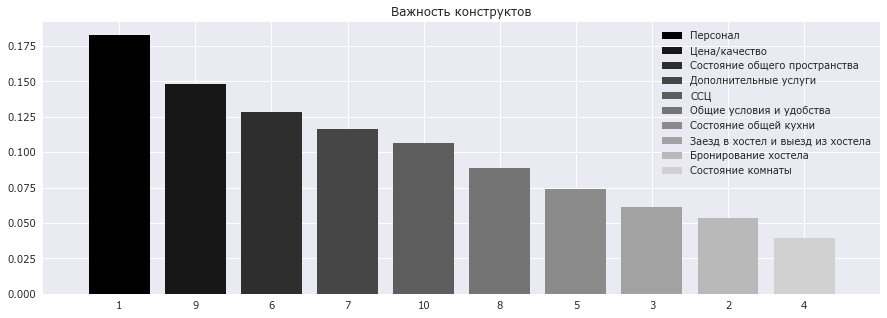

In [2]:
hostel_data = pd.read_csv("../data/hostel_factors.csv")
features = {"f1":u"Персонал",
"f2":u"Бронирование хостела ",
"f3":u"Заезд в хостел и выезд из хостела",
"f4":u"Состояние комнаты",
"f5":u"Состояние общей кухни",
"f6":u"Состояние общего пространства",
"f7":u"Дополнительные услуги",
"f8":u"Общие условия и удобства",
"f9":u"Цена/качество",
"f10":u"ССЦ"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

На рисунке выше видно, что люди больше всего обращают внимание на персонал и соотношение цена/качество и на основе впечатления от данных вещей пишут свои отзывы. Но разница между этими признаками и менее влиятельными признаками не очень значительная, и выкидывание какого-то признака приведет к уменьшению точности нашей модели. Но даже на основе нашего анализа мы можем дать рекомендации отелям в первую очередь лучше готовить персонал и/или улучшить качество до заявленной цены. 
